# Install and import dependencies

In [ ]:
!pip install seaborn
!pip install bertopic
!pip install emoji
!pip install nltk
!pip install matplotlib
!pip install pyLDAvis
!pip install sentence-transformers scikit-learn pandas
!pip install gensim
!pip install kaleido
!pip install huggingface_hub

In [ ]:
import os

from bertopic import BERTopic

import pandas as pd
import numpy as np
import altair as alt
from datetime import datetime
from huggingface_hub import snapshot_download

import matplotlib.pyplot as plt

# Set Plotting Theme

In [6]:
custom_theme = {
    "config": {
        "title": {"font": "Helvetica", "fontSize": 12},
        "axis": {
            "labelFont": "Helvetica",
            "labelFontSize": 12,
            "titleFont": "Helvetica",
            "titleFontSize": 12
        },
        "legend": {
            "labelFont": "Helvetica",
            "labelFontSize": 12,
            "titleFont": "Helvetica",
            "titleFontSize": 12
        }
    }
}

alt.themes.register('custom_helvetica', lambda: custom_theme)
alt.themes.enable('custom_helvetica')

/tmp/ipython-input-65927896.py:19: AltairDeprecationWarning: 
Deprecated since `altair=5.5.0`. Use altair.theme instead.
Most cases require only the following change:

    # Deprecated
    alt.themes.enable('quartz')

    # Updated
    alt.theme.enable('quartz')

If your code registers a theme, make the following change:

    # Deprecated
    def custom_theme():
        return {'height': 400, 'width': 700}
    alt.themes.register('theme_name', custom_theme)
    alt.themes.enable('theme_name')

    # Updated
    @alt.theme.register('theme_name', enable=True)
    def custom_theme():
        return alt.theme.ThemeConfig(
            {'height': 400, 'width': 700}
        )

See the updated User Guide for further details:
    https://altair-viz.github.io/user_guide/api.html#theme
    https://altair-viz.github.io/user_guide/customization.html#chart-themes
  alt.themes.register('custom_helvetica', lambda: custom_theme)


ThemeRegistry.enable('custom_helvetica')

# Visualize Temporal Results Over Acres Burnt

In [ ]:
# Define your fire data
data = [
    {"Date": "January 7, 2025",  "Fire Name": "Palisades Fire", "Acres Burned": 1262,    "Containment": 0,  "Status": "ACTIVE"},
    {"Date": "January 7, 2025",  "Fire Name": "Eaton Fire",     "Acres Burned": 1000,    "Containment": 0,  "Status": "ACTIVE"},
    {"Date": "January 8, 2025",  "Fire Name": "Palisades Fire", "Acres Burned": 15832,   "Containment": 0,  "Status": "ACTIVE"},
    {"Date": "January 8, 2025",  "Fire Name": "Eaton Fire",     "Acres Burned": 10600,   "Containment": 0,  "Status": "ACTIVE"},
    {"Date": "January 9, 2025",  "Fire Name": "Palisades Fire", "Acres Burned": 17234,   "Containment": 0,  "Status": "ACTIVE"},
    {"Date": "January 9, 2025",  "Fire Name": "Eaton Fire",     "Acres Burned": 14117,   "Containment": 0,  "Status": "ACTIVE"},
    {"Date": "January 10, 2025", "Fire Name": "Palisades Fire", "Acres Burned": 20483.2, "Containment": 8,  "Status": "ACTIVE"},
    {"Date": "January 10, 2025", "Fire Name": "Eaton Fire",     "Acres Burned": 13956.3, "Containment": 3,  "Status": "ACTIVE"},
    {"Date": "January 11, 2025", "Fire Name": "Palisades Fire", "Acres Burned": 23342.8, "Containment": 11, "Status": "ACTIVE"},
    {"Date": "January 11, 2025", "Fire Name": "Eaton Fire",     "Acres Burned": 14117,   "Containment": 15, "Status": "ACTIVE"},
    {"Date": "January 12, 2025", "Fire Name": "Palisades Fire", "Acres Burned": 23713,   "Containment": 13, "Status": "ACTIVE"},
    {"Date": "January 12, 2025", "Fire Name": "Eaton Fire",     "Acres Burned": 14117,   "Containment": 27, "Status": "ACTIVE"},
    {"Date": "January 13, 2025", "Fire Name": "Palisades Fire", "Acres Burned": 23713,   "Containment": 14, "Status": "ACTIVE"},
    {"Date": "January 13, 2025", "Fire Name": "Eaton Fire",     "Acres Burned": 14117,   "Containment": 33, "Status": "ACTIVE"},
    {"Date": "January 14, 2025", "Fire Name": "Palisades Fire", "Acres Burned": 23713,   "Containment": 17, "Status": "ACTIVE"},
    {"Date": "January 14, 2025", "Fire Name": "Eaton Fire",     "Acres Burned": 14117,   "Containment": 35, "Status": "ACTIVE"},
    {"Date": "January 15, 2025", "Fire Name": "Palisades Fire", "Acres Burned": 23713,   "Containment": 19, "Status": "ACTIVE"},
    {"Date": "January 15, 2025", "Fire Name": "Eaton Fire",     "Acres Burned": 14117,   "Containment": 45, "Status": "ACTIVE"},
]

acres_df = pd.DataFrame(data)
acres_df["Date"] = pd.to_datetime(acres_df["Date"])

# ------------------------------
# Chart 1: Burned Acres as a red line chart with peak annotations
# ------------------------------
chart_acres = alt.Chart(acres_df).mark_line(point=False).encode(
    x=alt.X('Date:T', axis=alt.Axis(format='%b %d', labelAngle=0, labelFontSize=10)),
    y=alt.Y('Acres Burned:Q',
            axis=alt.Axis(title='Acres Burned', format=".0~s", values=[10000, 20000], labelColor='black', titleColor='black')),
    color=alt.Color('Fire Name:N',
                    scale=alt.Scale(domain=['Palisades Fire', 'Eaton Fire'],
                                    range=['crimson', 'purple']),
                    legend=alt.Legend(title="Fire Name"))
).properties(width=300, height=300)

# Calculate peak points for burned acres per fire
peak_df = acres_df.loc[acres_df.groupby("Fire Name")["Acres Burned"].idxmax()]

peak_points = alt.Chart(peak_df).mark_point(filled=True, size=100).encode(
    x='Date:T',
    y='Acres Burned:Q',
    color=alt.Color('Fire Name:N',
                    scale=alt.Scale(domain=['Palisades Fire', 'Eaton Fire'],
                                    range=['crimson', 'purple']))
)

peak_text = alt.Chart(peak_df).mark_text(align='left', dx=5, dy=-5, fontSize=10).encode(
    x='Date:T',
    y='Acres Burned:Q',
    text='Acres Burned:Q',
    color=alt.Color('Fire Name:N',
                    scale=alt.Scale(domain=['Palisades Fire', 'Eaton Fire'],
                                    range=['crimson', 'purple']))
)

chart_acres = chart_acres + peak_points + peak_text

# ------------------------------
# Chart 2: Containment (Dashed Blue Line Chart)
# ------------------------------
chart_cont = alt.Chart(acres_df).mark_line(point=False, strokeDash=[5,5]).encode(
    x=alt.X('Date:T', axis=alt.Axis(format='%b %d', labelAngle=0, labelFontSize=10)),
    y=alt.Y('Containment:Q',
            axis=alt.Axis(title='Containment (%)', labelColor='black', titleColor='black')),
    color=alt.Color('Fire Name:N',
                    scale=alt.Scale(domain=['Palisades Fire', 'Eaton Fire'],
                                    range=['crimson', 'purple']),
                    legend=alt.Legend(title="Fire Name"))
).properties(width=300, height=300)

# ------------------------------
# Combine the two charts side-by-side
# ------------------------------
final_chart = alt.hconcat(chart_acres, chart_cont).resolve_scale(y='independent')
final_chart

# Download and Load Optimized Model

In [ ]:
# Download load comments datasets.
model_path = snapshot_download(
    repo_id="Dragmoon/BERTopicFire",
    local_dir="./models"
)

model_ft = BERTopic.load(os.path.join(model_path, 'safetensor'))

# Download and Load Datasets

In [ ]:
# Download load comments datasets.
dataset_path = snapshot_download(
    repo_id="Dragmoon/2025CalifoniaWildfire",
    repo_type="dataset",
    local_dir="./datasets"
)

# Preview Dataset

In [84]:
comments = pd.read_csv(os.path.join(dataset_path, 'reddit/all_final_comments.csv'))
comments.head(2)

,post_id,comment_id,author,body,score,created_utc,corpus,corpus_length
0,8eb4a7f25baa08ab,b7a0a265b0a28462,72d3ca82b6f74987,A lot of people put their Christmas trees out ...,68,2025-01-07 20:42:05,a lot of people put their christmas trees out ...,31
1,8eb4a7f25baa08ab,8442054266b04ba2,9822bf44dcd5e160,Just want to say I’m proud of our neighborhood...,44,2025-01-08 06:50:05,just want to say im proud of our neighborhood ...,17


In [85]:
short_comments = comments[comments['corpus_length'] < 10]
long_comments = comments[comments['corpus_length'] >= 10]

In [86]:
join_comments = pd.read_csv(os.path.join(dataset_path, 'reddit/comments_join_multiple_label.csv'))
join_comment_select = join_comments[['corpus', 'created_utc', 'Situational Awareness', 'Crisis Narrative', 'Grief', 'Mental']]
join_comment_select.head(2)

,corpus,created_utc,Situational Awareness,Crisis Narrative,Grief,Mental
0,just want to say im proud of our neighborhood ...,2025-01-08 06:50:05,"Recovery,Loss and damage","Renewal,Victim",checked,checked
1,altadena herelake and ny drivejust got an emai...,2025-01-08 00:03:16,"Public health and safety,Emergency resources,L...","Blame,Victim",checked,NaN


In [87]:
posts_df = pd.read_csv(os.path.join(dataset_path, 'reddit/all_final_posts_multiple_label.csv'))
posts_select = posts_df[['Clean Text', 'Date', 'Situational Awareness', 'Crisis Narrative', 'Grief', 'Mental']]
posts_select.head(2)

,Clean Text,Date,Situational Awareness,Crisis Narrative,Grief,Mental
0,"I need to vent. Hey folks, apologies in advanc...",2025-01-16 04:06:40,Loss and damage,Victim,checked,checked
1,Elevated Lead and Chlorine Levels During LA Wi...,2025-01-20 17:55:53,"Public health and safety,Influential figures","Victim,Blame",checked,checked


In [88]:
join_comment_select.columns = posts_select.columns
post_comment = pd.concat([join_comment_select, posts_select], ignore_index=True)
post_comment.head(2)

,Clean Text,Date,Situational Awareness,Crisis Narrative,Grief,Mental
0,just want to say im proud of our neighborhood ...,2025-01-08 06:50:05,"Recovery,Loss and damage","Renewal,Victim",checked,checked
1,altadena herelake and ny drivejust got an emai...,2025-01-08 00:03:16,"Public health and safety,Emergency resources,L...","Blame,Victim",checked,NaN


In [89]:
post_comment = post_comment[post_comment['Crisis Narrative'].notna()]
post_comment.shape

(40688, 6)

# Overall temporal patterns of wildfire progression (Figure 4 in the Paper)

In [ ]:
trend = post_comment.copy()
trend["Date"] = pd.to_datetime(trend["Date"])
trend["Day"] = trend["Date"].dt.floor("D")
daily_counts = (
    trend.groupby("Day")
      .size()
      .reset_index(name="Count")
      .sort_values("Day")
)

acres_df["Day"] = pd.to_datetime(acres_df["Date"])
acres_df["Day"] = acres_df["Date"].dt.floor("D")

cutoff = pd.Timestamp("2025-01-16")
daily_counts = daily_counts[daily_counts["Day"] < cutoff]

daily_counts["Day_str"] = daily_counts["Day"].dt.strftime("%b %d")
acres_df["Day_str"] = acres_df["Day"].dt.strftime("%b %d")


x_axis = alt.Axis(labelAngle=0, labelFontSize=12)

bar = alt.Chart(daily_counts).mark_bar(color="lightgray", size=40).encode(
    x=alt.X("Day_str:N", title="Date", axis=x_axis),
    y=alt.Y("Count:Q", title="Total Count of Reddit Data", axis =alt.Axis(tickCount=5))
)

line = alt.Chart(acres_df).mark_line(point=False).encode(
    x=alt.X("Day_str:N", axis=x_axis),
    y=alt.Y('Acres Burned:Q',
            axis=alt.Axis(
                title='Acres Burned',
                format=".0~s",
                values=[10000, 20000],
                labelColor='black',
                titleColor='black')),
    color=alt.Color('Fire Name:N',
                    scale=alt.Scale(domain=['Palisades Fire', 'Eaton Fire'],
                                    range=['crimson', 'purple']),
                    legend=alt.Legend(title="Fire Name"))
).properties(width=300, height=300)

# Calculate peak points for burned acres per fire
peak_df = acres_df.loc[acres_df.groupby("Fire Name")["Acres Burned"].idxmax()]

peak_points = alt.Chart(peak_df).mark_point(filled=True, size=100).encode(
    x="Day_str:N",
    y='Acres Burned:Q',
    color=alt.Color('Fire Name:N',
                    scale=alt.Scale(domain=['Palisades Fire', 'Eaton Fire'],
                                    range=['crimson', 'purple']))
)

peak_text = alt.Chart(peak_df).mark_text(align='left', dx=5, dy=-5, fontSize=10).encode(
    x="Day_str:N",
    y='Acres Burned:Q',
    text='Acres Burned:Q',
    color=alt.Color('Fire Name:N',
                    scale=alt.Scale(domain=['Palisades Fire', 'Eaton Fire'],
                                    range=['crimson', 'purple']))
)

line = line + peak_points + peak_text

combined = alt.layer(bar, line).resolve_scale(y="independent").properties(
    width=800, height=300
)

combined

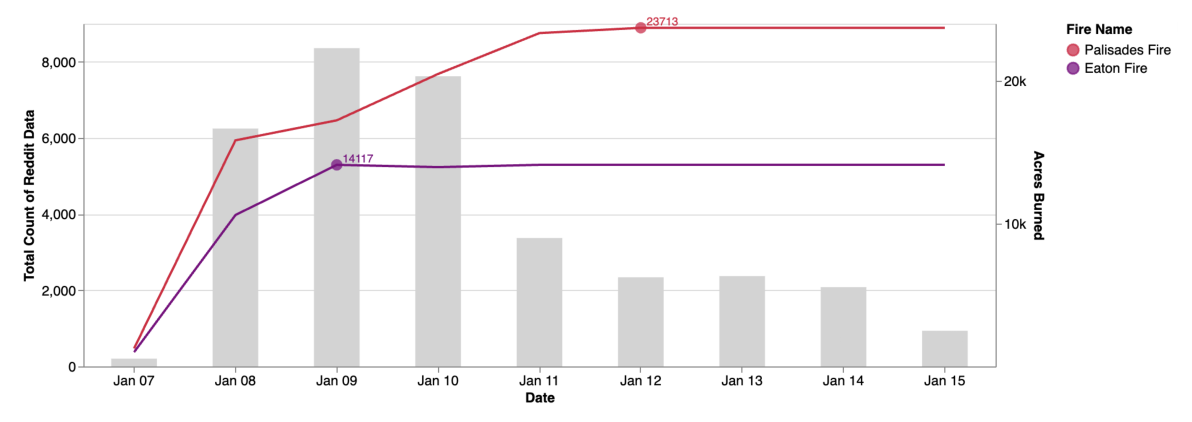

In [152]:
# Visualization only, the above cell should output this figure.

# Preview Emotional Distress

In [91]:
post_comment['Grief'] = post_comment['Grief'] == 'checked'
post_comment['Mental'] = post_comment['Mental'] == 'checked'
post_comment.head(5)

,Clean Text,Date,Situational Awareness,Crisis Narrative,Grief,Mental
0,just want to say im proud of our neighborhood ...,2025-01-08 06:50:05,"Recovery,Loss and damage","Renewal,Victim",True,True
1,altadena herelake and ny drivejust got an emai...,2025-01-08 00:03:16,"Public health and safety,Emergency resources,L...","Blame,Victim",True,False
3,my neighbors gardeners were out using leaf blo...,2025-01-07 23:33:18,"Public health and safety,Emergency resources,R...","Victim,Blame,Renewal",True,True
6,california blvd is complete blocked by two fal...,2025-01-08 05:33:55,"Fire operations,Loss and damage","Hero,Victim",False,False
7,we had a poweroutage from 6 in west altadena w...,2025-01-07 18:51:58,"Fire operations,Public health and safety,Recov...","Blame,Victim",True,False


In [92]:
post_comment['Grief'].sum()

np.int64(26257)

In [93]:
post_comment['Mental'].sum()

np.int64(19683)

In [94]:
post_comment['Date'] = pd.to_datetime(post_comment['Date'], format="%Y-%m-%d %H:%M:%S")

# Define a function to classify time of day
def classify_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Create a new column 'time_of_day' based on hour
post_comment['time_of_day'] = post_comment['Date'].dt.hour.apply(classify_time_of_day)

# Time sequence
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']

# time_of_day category
post_comment['time_of_day'] = pd.Categorical(post_comment['time_of_day'], categories=time_order, ordered=True)

# Clean
post_comment['Grief'] = post_comment['Grief'].fillna(False).astype(bool)
post_comment['Mental'] = post_comment['Mental'].fillna(False).astype(bool)

# Aggregate
summary_by_time = post_comment.groupby('time_of_day').agg(
    Total_Posts=('Grief', 'count'),
    Grief_Percent=('Grief', 'mean'),
    Mental_Percent=('Mental', 'mean')
).reset_index()

summary_by_time['Grief_Percent'] *= 100
summary_by_time['Mental_Percent'] *= 100

percent_df = summary_by_time.melt(
    id_vars=['time_of_day', 'Total_Posts'],
    value_vars=['Grief_Percent', 'Mental_Percent'],
    var_name='Type',
    value_name='Percent'
)

# Modify legend label
percent_df['Type'] = percent_df['Type'].replace({
    'Grief_Percent': 'Grief %',
    'Mental_Percent': 'Mental %'
})

# Diurnal Distribution across Four Time Segments

In [ ]:
bar = alt.Chart(summary_by_time).mark_bar(size=40, color='lightgray').encode(
    x=alt.X('time_of_day:N', title='Time of Day',
            sort=['Morning', 'Afternoon', 'Evening', 'Night'],
            axis=alt.Axis(labelAngle=0)),
    y=alt.Y('Total_Posts:Q', title='Total Crisis Narrative Count')
)

line = alt.Chart(percent_df).mark_line(point=True).encode(
    x=alt.X('time_of_day:N', title='Time of Day',
            sort=['Morning', 'Afternoon', 'Evening', 'Night'],
            axis=alt.Axis(labelAngle=0)),
    y=alt.Y('Percent:Q', title='Percentage (%)', scale=alt.Scale(domain=[0, 100])),
    color=alt.Color('Type:N', title='Type',
                    scale=alt.Scale(domain=['Grief %', 'Mental %'])),
    strokeDash=alt.StrokeDash('Type:N', title='Type',
                              scale=alt.Scale(domain=['Grief %', 'Mental %'],
                                              range=[[1, 0], [5, 3]])),
    tooltip=['time_of_day:N', 'Type:N', 'Percent:Q']
)

chart = alt.layer(
    bar,
    line
).resolve_scale(
    y='independent'
).properties(
    width=400,
    height=400,
    #title='Total Count of Reddit Data with Grief and Mental Risks Percentage by Time of Day'
)

axis=alt.Axis(labelAngle=0, labelFontSize=12, labelPadding=10)

chart

In [96]:
post_comment['Day'] = post_comment['Date'].dt.strftime('%Y-%m-%d')

# Ensure the column is string and split into lists
post_comment['Crisis Narrative'] = (
    post_comment['Crisis Narrative']
    .astype(str)
    .str.split(',')
)

# Optional but recommended: strip whitespace
post_comment['Crisis Narrative'] = post_comment['Crisis Narrative'].apply(
    lambda x: [i.strip() for i in x if i.strip()]
)

# Explode
post_comment_exploded = post_comment.explode('Crisis Narrative')

stack = (
    post_comment_exploded
    .groupby(['time_of_day', 'Crisis Narrative'])
    .size()
    .reset_index(name='count')
)

In [ ]:
time_axis = alt.Axis(labelAngle=0, labelFontSize=12, labelPadding=8)

stacked_hist = alt.Chart(stack).mark_bar(size=40).encode(
    x=alt.X(
        'time_of_day:N',
        title='Time of Day',
        sort=['Morning', 'Afternoon', 'Evening', 'Night'],
        axis=time_axis
    ),
    y=alt.Y(
        'count:Q',
        title='Aggregated CN Count (multi-label)',
        stack='zero'
    ),
    color=alt.Color(
        'Crisis Narrative:N',
        title='CN Category'
    ),
    tooltip=[
        alt.Tooltip('time_of_day:N', title='Time of Day'),
        alt.Tooltip('Crisis Narrative:N', title='CN Type'),
        alt.Tooltip('count:Q', title='Count')
    ]
).properties(
    width=400,
    height=400
)

stacked_hist

## This is Figure 8 in our Paper

In [ ]:
combined = alt.hconcat(
    chart,
    stacked_hist,
    spacing=12
).resolve_scale(
    color='independent'          # critical: separate color scales
).resolve_legend(
    color='independent',         # separate color legends
    strokeDash='independent'     # safe, since (a) uses strokeDash
)

combined

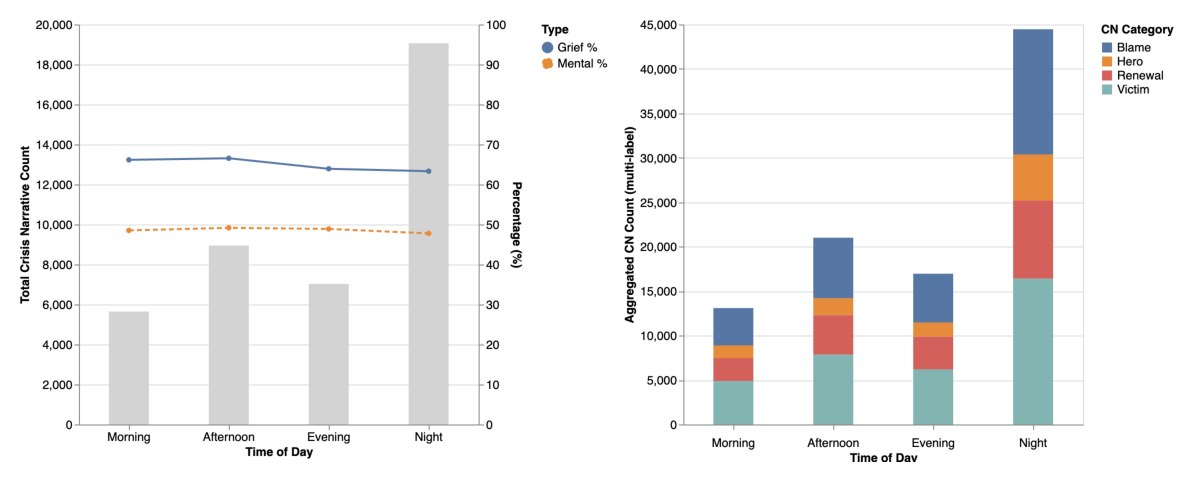

In [151]:
# Visualization only, the above cell should output this figure.

# Top Trend with the Fire Progression

In [100]:
# make sure Day is datetime
post_comment['Day'] = pd.to_datetime(post_comment['Day'])

# clean Grief 和 Mental
post_comment['Grief'] = post_comment['Grief'].fillna(False).astype(bool)
post_comment['Mental'] = post_comment['Mental'].fillna(False).astype(bool)

# Aggregate
summary_df = post_comment.groupby('Day').agg(
    Total_Posts=('Grief', 'count'),
    Grief_Percent=('Grief', 'mean'),
    Mental_Percent=('Mental', 'mean')
).reset_index()

# Percentage
summary_df['Grief_Percent'] *= 100
summary_df['Mental_Percent'] *= 100

In [101]:
# Melt into long format for Altair
percent_df = summary_df.melt(
    id_vars=['Day', 'Total_Posts'],
    value_vars=['Grief_Percent', 'Mental_Percent'],
    var_name='Type',
    value_name='Percent'
)
# Optional: make legend labels cleaner
percent_df['Type'] = percent_df['Type'].replace({
    'Grief_Percent': 'Grief %',
    'Mental_Percent': 'Mental %'
})

In [ ]:
# Bar for Total Posts (left Y axis)
bar = alt.Chart(summary_df).mark_bar(color='lightgray', size = 15).encode(
    x=alt.X('Day:T', title='Date', axis=alt.Axis(format='%b %d')),
    y=alt.Y('Total_Posts:Q', title='Total Crisis Narrative Count')
)

# Line for Grief % and Mental % (right Y axis with shared legend)
line = alt.Chart(percent_df).mark_line(point=True).encode(
    x='Day:T',
    y=alt.Y('Percent:Q', title='Percentage (%)', axis=alt.Axis(titleColor='black')),
    color=alt.Color('Type:N', title='Type'),
    strokeDash=alt.StrokeDash('Type:N', title='Type'),  # Dashed for Mental
    tooltip=['Day:T', 'Type:N', 'Percent:Q']
)

# Combine with dual y-axes
chart = alt.layer(
    bar,
    line
).resolve_scale(
    y = 'independent'
).properties(
    width=800,
    height=400,
    #title='Post Volume and Emotional Expression by Day'
)

chart

# Temporal trends of CN

In [103]:
cutoff = pd.Timestamp("2025-01-16")
post_comment_cut = post_comment[post_comment["Date"] < cutoff]
post_comment_cut.shape

(33532, 8)

In [104]:
# Aggregate
summary_by_cut = post_comment_cut.groupby('Day').agg(
    Total_Posts=('Grief', 'count'),
    Grief_Percent=('Grief', 'mean'),
    Mental_Percent=('Mental', 'mean')
).reset_index()

# Percentage
summary_by_cut['Grief_Percent'] *= 100
summary_by_cut['Mental_Percent'] *= 100

In [105]:
# Melt into long format for Altair
percent_df = summary_by_cut.melt(
    id_vars=['Day', 'Total_Posts'],
    value_vars=['Grief_Percent', 'Mental_Percent'],
    var_name='Type',
    value_name='Percent'
)
# Optional: make legend labels cleaner
percent_df['Type'] = percent_df['Type'].replace({
    'Grief_Percent': 'Grief %',
    'Mental_Percent': 'Mental %'
})

In [106]:
# Compute padded temporal domain
xmin = summary_by_cut["Day"].min() - pd.Timedelta(days=0.5)
xmax = summary_by_cut["Day"].max() + pd.Timedelta(days=0.5)

x_scale = alt.Scale(domain=[xmin, xmax])

In [ ]:
# Bar for Total Posts (left Y axis)
bar = alt.Chart(summary_by_cut).mark_bar(color='lightgray', size = 15).encode(
    x=alt.X('Day:T', title='Date', axis=alt.Axis(format='%b %d'), scale=x_scale),
    y=alt.Y('Total_Posts:Q', title='Total Crisis Narrative Count'),
)

# Line for Grief % and Mental % (right Y axis with shared legend)
line = alt.Chart(percent_df).mark_line(point=True).encode(
    x='Day:T',
    y=alt.Y('Percent:Q', title='Percentage (%)', axis=alt.Axis(titleColor='black')),
    color=alt.Color('Type:N', title='Type'),
    strokeDash=alt.StrokeDash('Type:N', title='Type'),  # Dashed for Mental
    tooltip=['Day:T', 'Type:N', 'Percent:Q']
)

# Combine with dual y-axes
date_chart = alt.layer(
    bar,
    line
).resolve_scale(
    y = 'independent'
).properties(
    width=400,
    height=400,
    #title='Post Volume and Emotional Expression by Day'
)

date_chart

In [109]:
# Explode
post_comment_cut_exploded = post_comment_cut.explode('Crisis Narrative')

stack_cut = (
    post_comment_cut_exploded
    .groupby(['Day', 'Crisis Narrative'])
    .size()
    .reset_index(name='count')
)

In [ ]:
time_axis = alt.Axis(labelAngle=0, labelFontSize=12, labelPadding=8)

stacked_cut_hist = alt.Chart(stack_cut).mark_bar(size=40).encode(
    x=alt.X('Day:T', title='Date', axis=alt.Axis(format='%b %d'), scale=x_scale),
    y=alt.Y(
        'count:Q',
        title='Aggregated CN Count (multi-label)',
        stack='zero'
    ),
    color=alt.Color(
        'Crisis Narrative:N',
        title='CN Category'
    ),
    tooltip=[
        alt.Tooltip('Day:N', title='Date'),
        alt.Tooltip('Crisis Narrative:N', title='CN Type'),
        alt.Tooltip('count:Q', title='Count')
    ]
).properties(
    width=400,
    height=400
)

stacked_cut_hist

## This is Figure 7 in our Paper

In [ ]:
# =========================
# Side-by-side
# =========================
combined_date = alt.hconcat(
    date_chart,
    stacked_cut_hist,
    spacing=12
).resolve_scale(
    color='independent'          # critical: separate color scales
).resolve_legend(
    color='independent',         # separate color legends
    strokeDash='independent'     # safe, since (a) uses strokeDash
)

combined_date

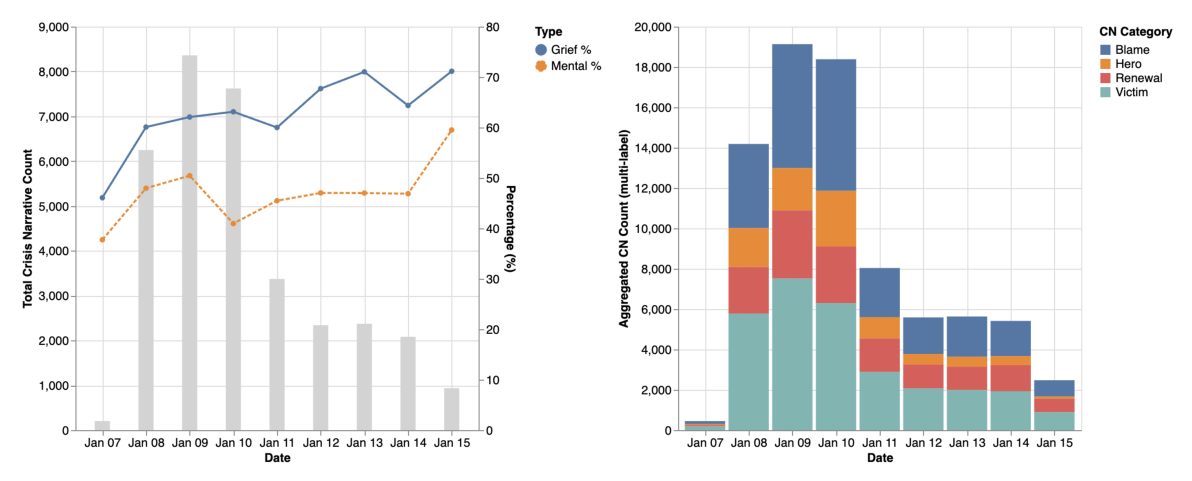

In [150]:
# Visualization only, the above cell should output this figure.

# A hierarchical structure of all the topics (Appendix C in the Paper)

In [ ]:
hierarchical_topics = model_ft.hierarchical_topics(long_comments['corpus'])

In [ ]:
model_ft.visualize_hierarchy(custom_labels=True)

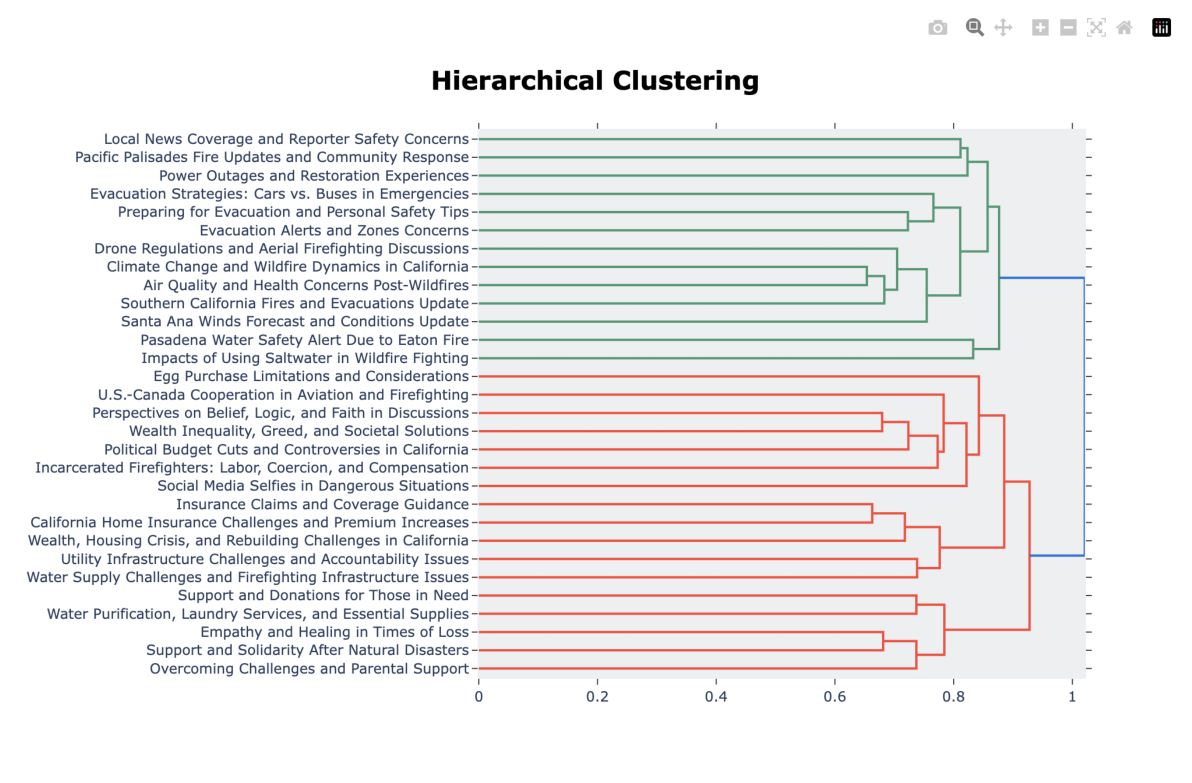

In [144]:
# Viualization only. Above line should output this figure

In [116]:
long_comments['date'] = long_comments['created_utc'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())

In [117]:
long_comments.head(5)

,post_id,comment_id,author,body,score,created_utc,corpus,corpus_length,date
0,8eb4a7f25baa08ab,b7a0a265b0a28462,72d3ca82b6f74987,A lot of people put their Christmas trees out ...,68,2025-01-07 20:42:05,a lot of people put their christmas trees out ...,31,2025-01-07
1,8eb4a7f25baa08ab,8442054266b04ba2,9822bf44dcd5e160,Just want to say I’m proud of our neighborhood...,44,2025-01-08 06:50:05,just want to say im proud of our neighborhood ...,17,2025-01-08
2,8eb4a7f25baa08ab,4232aa04196bfc38,3475e9939d215907,Hoping it won’t be as bad as the 2011 event.,29,2025-01-07 18:28:57,hoping it wont be as bad as the 2011 event,10,2025-01-07
3,8eb4a7f25baa08ab,62edf12d514906a3,5126968ff96d0bcf,"Saw a tree that had fallen on a car, a down po...",26,2025-01-07 19:15:50,saw a tree that had fallen on a car a down pow...,26,2025-01-07
4,8eb4a7f25baa08ab,c6537cc1180dc4b8,0f8909a299ff486a,An Evacuation Shelter has been established at ...,25,2025-01-08 06:06:55,an evacuation shelter has been established at ...,23,2025-01-08


# Visualize Topic over time

In [46]:
topics_over_time = model_ft.topics_over_time(long_comments['corpus'], long_comments['date'])

38it [05:55,  9.36s/it]


In [118]:
topics_over_time

,Topic,Words,Frequency,Timestamp,Name
0,-1,"cars, wind, fire, car, evacuate",311,2025-01-07,Outlier Topic
1,0,"sparks, crack down, think climate, buildings b...",25,2025-01-07,Climate Change and Wildfire Dynamics in Califo...
2,1,"creeping its, restricts the, quality without, ...",14,2025-01-07,Drone Regulations and Aerial Firefighting Disc...
3,2,"steve, steve guttenberg, guttenberg, also cry,...",13,2025-01-07,"Wealth Inequality, Greed, and Societal Solutions"
4,3,"smoke, see smoke, actively see, smoke blowing,...",11,2025-01-07,Air Quality and Health Concerns Post-Wildfires
...,...,...,...,...,...
854,5,"rust, washed in, much crazy, rust more, best deal",3,2025-02-13,"Water Purification, Laundry Services, and Esse..."
855,6,"well face, immediate thought, my immediate, th...",1,2025-02-13,"Perspectives on Belief, Logic, and Faith in Di..."
856,7,"beige, no preservation, ptsd looking, it beige...",3,2025-02-13,Empathy and Healing in Times of Loss
857,14,"proud of, music people, proud, music, parents",19,2025-02-13,Overcoming Challenges and Parental Support


In [119]:
fig_t = model_ft.visualize_topics_over_time(topics_over_time, custom_labels=True, topics=[3,5,23,26])

## Default Visualization

In [ ]:
fig_t.update_layout(
    title_text="",  # Change the figure title
    legend_title=dict(
        text="<b>Selected Health Realted Topics</b>",  # Legend title in bold
        font=dict(size=14)
    ),
    legend=dict(
        x=0.6,  # horizontal position (0 = left, 1 = right)
        y=1,  # vertical position (0 = bottom, 1 = top)
        bgcolor="rgba(255,255,255,0)",  # optional: transparent background
        bordercolor="Black",            # optional: border color
        borderwidth=1,
        font=dict(size=12, family="Helvetica")
    ),
    yaxis=dict(
        title= dict(text = "<b>Frequency<b>", font=dict(size=14, family="Helvetica")),
        tickfont=dict(size=12, family="Helvetica")
    ),
    xaxis=dict(
        tickfont=dict(size=12, family="Helvetica")
    )
)

fig_t.show()

In [50]:
# Optionally, save the figure.
# fig_t.write_image("figures/topic_over_time.png", width=1666, height=708, scale=1)

## Temporal trends and domain keywords of topics (Figure 5 in the Paper)

In [ ]:
topics_over_time_select = topics_over_time[topics_over_time['Topic'].isin([3, 5, 23, 26])]

topics_over_time_select['Name'].unique()

df = topics_over_time_select.copy()
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

df_day = (df
          .groupby(["Timestamp", "Topic", "Name"], as_index=False)["Frequency"]
          .sum())

xmin = df_day["Timestamp"].min() - pd.Timedelta(days=0.5)
xmax = df_day["Timestamp"].max() + pd.Timedelta(days=0.5)

topic_order = topics_over_time_select['Name'].unique()

line_chart = alt.Chart(df_day).mark_line(point=False).encode(
    x=alt.X(
        "Timestamp:T",
        title="Date",
        axis=alt.Axis(format="%b %d", labelFontSize=14, titleFontSize=16),
        scale=alt.Scale(domain=[xmin, xmax])
    ),
    y=alt.Y(
        "Frequency:Q",
        title="Frequency",
        axis=alt.Axis(tickCount=5, labelFontSize=14, titleFontSize=16)
    ),
    color=alt.Color(
        "Name:N",
        sort=topic_order,
        scale=alt.Scale(
            domain=topic_order,
            range=["#E45756", "#4C78A8", "#F58518", "#72B7B2"]
        ),
        title=None,
        legend=alt.Legend(
            orient="none",
            legendX=500,
            legendY=10,
            direction="vertical",

            # readability
            labelFontSize=14,
            labelLimit=1000,          # increase to avoid truncation
            labelPadding=6,
            symbolSize=120,
            symbolStrokeWidth=2,
            padding=10,

            # legend box background / border color (no strokeWidth available)
            fillColor="white",
            strokeColor="lightgray"
        )
    ),
    tooltip=[
        alt.Tooltip("Timestamp:T", title="Date", format="%Y-%m-%d"),
        alt.Tooltip("Name:N", title="Topic"),
        alt.Tooltip("Frequency:Q", title="Frequency")
    ]
).properties(
    width=1000,
    height=300
)

line_chart

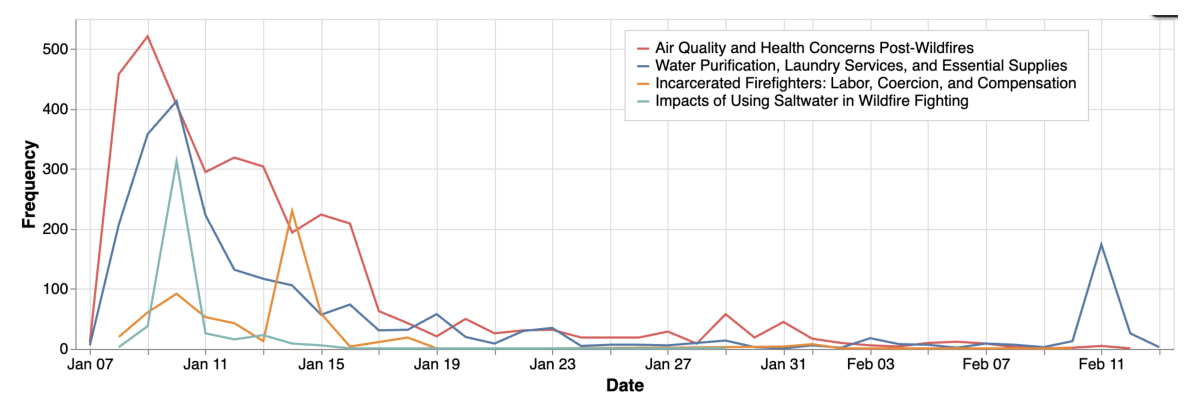

In [149]:
# Visualization only, the above cell should output this figure.

# Trend over Fire Events

In [122]:
eaton_posts = pd.read_csv(os.path.join(dataset_path, 'reddit/eaton_final_posts.csv'))['post_id'].tolist()
palisades_posts = pd.read_csv(os.path.join(dataset_path, 'reddit/palisades_final_posts.csv'))['post_id'].tolist()

In [123]:
# Define a function to assign fire_name based on post_id
def get_fire_name(post_id):
    fires = []
    if post_id in eaton_posts:
        fires.append('Eaton')
    if post_id in palisades_posts:
        fires.append('Palisades')

    if len(fires) > 1:
        return 'common'
    elif len(fires) == 1:
        return fires[0]
    else:
        return 'other'

# Create a new column 'fire_name' in the DataFrame
long_comments['fire_name'] = long_comments['post_id'].apply(get_fire_name)

In [124]:
long_comments['fire_name'].value_counts()

,count
fire_name,
common,28648
Palisades,26038
Eaton,17210
other,5298


In [125]:
long_comments.head(5)

,post_id,comment_id,author,body,score,created_utc,corpus,corpus_length,date,fire_name
0,8eb4a7f25baa08ab,b7a0a265b0a28462,72d3ca82b6f74987,A lot of people put their Christmas trees out ...,68,2025-01-07 20:42:05,a lot of people put their christmas trees out ...,31,2025-01-07,Eaton
1,8eb4a7f25baa08ab,8442054266b04ba2,9822bf44dcd5e160,Just want to say I’m proud of our neighborhood...,44,2025-01-08 06:50:05,just want to say im proud of our neighborhood ...,17,2025-01-08,Eaton
2,8eb4a7f25baa08ab,4232aa04196bfc38,3475e9939d215907,Hoping it won’t be as bad as the 2011 event.,29,2025-01-07 18:28:57,hoping it wont be as bad as the 2011 event,10,2025-01-07,Eaton
3,8eb4a7f25baa08ab,62edf12d514906a3,5126968ff96d0bcf,"Saw a tree that had fallen on a car, a down po...",26,2025-01-07 19:15:50,saw a tree that had fallen on a car a down pow...,26,2025-01-07,Eaton
4,8eb4a7f25baa08ab,c6537cc1180dc4b8,0f8909a299ff486a,An Evacuation Shelter has been established at ...,25,2025-01-08 06:06:55,an evacuation shelter has been established at ...,23,2025-01-08,Eaton


In [ ]:
topics_per_class = model_ft.topics_per_class(long_comments['corpus'], long_comments['fire_name'])

In [126]:
topics_per_class[~topics_per_class['Class'].isin(['other', 'common'])]

,Topic,Words,Frequency,Class
31,-1,"fire, in, was, that, it",10362,Palisades
32,0,"climate, climate change, change, fires, fire",1704,Palisades
33,1,"drone, drones, flying, fly, plane",2444,Palisades
34,2,"he, his, him, hes, she",1484,Palisades
35,3,"smoke, air, air quality, smell, ash",362,Palisades
...,...,...,...,...
119,25,"power, outage, no power, power is, outages",119,Eaton
120,26,"salt, salt water, water, seawater, the salt",26,Eaton
121,27,"eggs, rocks, eggs are, them subbed, green tops",13,Eaton
122,28,"selfies, selfie, taking, pictures, taking selfies",257,Eaton


In [131]:
fig_c = model_ft.visualize_topics_per_class(topics_per_class[~topics_per_class['Class'].isin(['other', 'common'])], custom_labels=True, topics=[3,5,23,26])

## Default Visualization

In [ ]:
fig_c.update_layout(
    plot_bgcolor='rgba(255, 255, 255, 0.5)',
    title_text="",  # Change the figure title
    legend_title=dict(
        text="<b>Selected Health Realted Latent Topics</b>",  # Legend title in bold
        font=dict(size=22, family="Helvetica")
    ),
    legend=dict(
        x=0.5,  # horizontal position (0 = left, 1 = right)
        y=0.5,  # vertical position (0 = bottom, 1 = top)
        bgcolor="rgba(255,255,255,0)",  # optional: transparent background
        bordercolor="grey",            # optional: border color
        borderwidth=0.6,
        traceorder="normal",
        font=dict(size=22, family="Helvetica")
    ),
    yaxis=dict(
        title= dict(text = "<b>Fire Events<b>", font=dict(size=22, family="Helvetica")),  # You can also use plain text like "Frequency"
        tickfont=dict(size=22, family="Helvetica"),
        categoryorder='array',
        categoryarray=['Eaton', 'Palisades'],  # specify your desired order
    ),
    xaxis=dict(
        title= dict(text = "<b>Frequency<b>", font=dict(size=22, family="Helvetica")),
        tickfont=dict(size=22, family="Helvetica")
    )
)

for trace in fig_c.data:
    trace.visible = True

fig_c.show()

In [61]:
# Optionally, save the figure.
# fig_c.write_image("figures/topic_over_fire.png", width=1050, height=800, scale=2)

## Comparison between the Palisades and Eaton Fires (Figure 6b in the Paper)

In [ ]:
topics_health = topics_per_class[~topics_per_class['Class'].isin(['other', 'common']) & topics_per_class['Topic'].isin([3, 5, 23, 26])]

topic_name_map = {
    3: "Air Quality and Health Concerns Post-Wildfires",
    5: "Water Purification, Laundry Services, and Essential Supplies",
    23: "Incarcerated Firefighters: Labor, Coercion, and Compensation",
    26: "Impacts of Using Saltwater in Wildfire Fighting"
}

topics_health["Name"] = topics_health["Topic"].map(topic_name_map)
topics_health

topic_order = topics_over_time_select['Name'].unique().tolist()

bar_chart = alt.Chart(topics_health).mark_bar().encode(
    y=alt.Y("Class:N", title="Fire Events", axis=alt.Axis(labelFontSize=14, titleFontSize=16)),
    yOffset=alt.YOffset("Name:N", sort=topic_order, title=None),
    x=alt.X("Frequency:Q", title="Frequency", axis=alt.Axis(labelFontSize=14, tickCount=5, titleFontSize=16)),
    color=alt.Color(
        "Name:N",
        sort=topic_order,
        scale=alt.Scale(
            domain=topic_order,
            range=["#E45756", "#4C78A8", "#F58518", "#72B7B2"]
        ),
        legend=alt.Legend(
            orient="none",
            legendX=400,
            legendY=285,
            direction="vertical",

            # readability
            title=None,
            labelFontSize=14,
            labelLimit=1000,          # increase to avoid truncation
            labelPadding=6,
            symbolSize=120,
            symbolStrokeWidth=2,
            padding=10,

            # legend box background / border color (no strokeWidth available)
            fillColor="white",
            strokeColor="lightgray"
        )
    ),
    tooltip=[
        alt.Tooltip("Class:N", title="Event"),
        alt.Tooltip("Name:N", title="Topic"),
        alt.Tooltip("Frequency:Q", title="Frequency")
    ]
).properties(width=850, height=400)

bar_chart


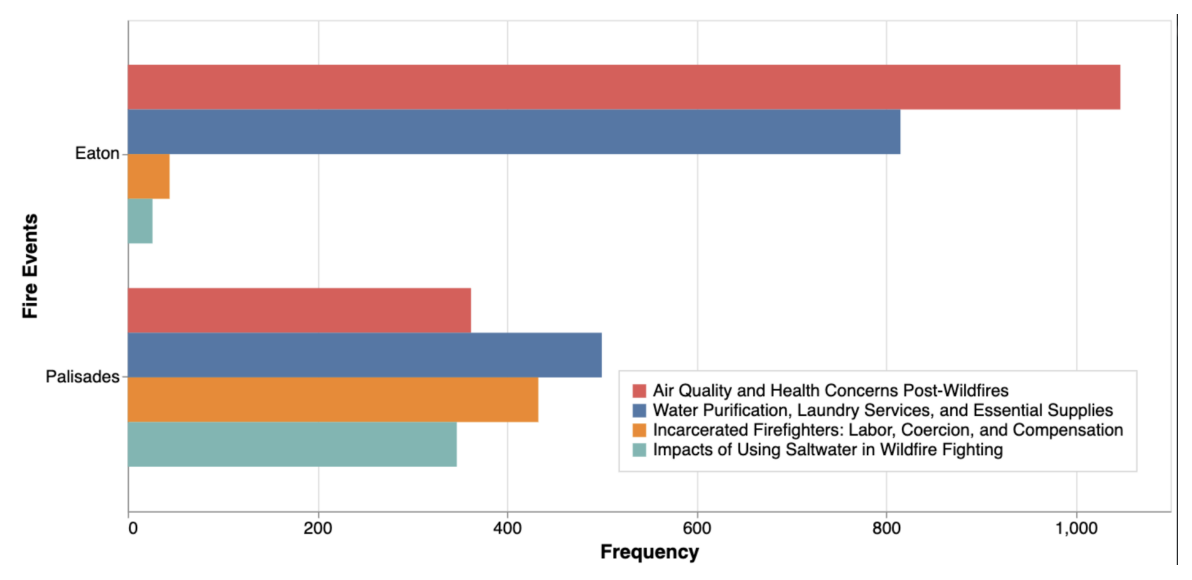

In [147]:
# Visualization only, above cell should output this figure.